<a href="https://colab.research.google.com/github/angeloken/Riset-I-smile/blob/main/riset_prediksi_listrik_ver_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
#import important library
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import date
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import itertools
import logging
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
%matplotlib inline

In [92]:
df = pd.read_csv('/content/opsd_germany_daily.csv')

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         4383 non-null   object 
 1   Consumption  4383 non-null   float64
 2   Wind         2920 non-null   float64
 3   Solar        2188 non-null   float64
 4   Wind+Solar   2187 non-null   float64
dtypes: float64(4), object(1)
memory usage: 171.3+ KB


In [94]:
df = df[['Date','Consumption']]

In [95]:
df['Date'] = pd.to_datetime(df['Date'])

In [96]:
df.set_index(df['Date'],inplace=True)


In [97]:
df=df.drop(['Date'],axis=1)

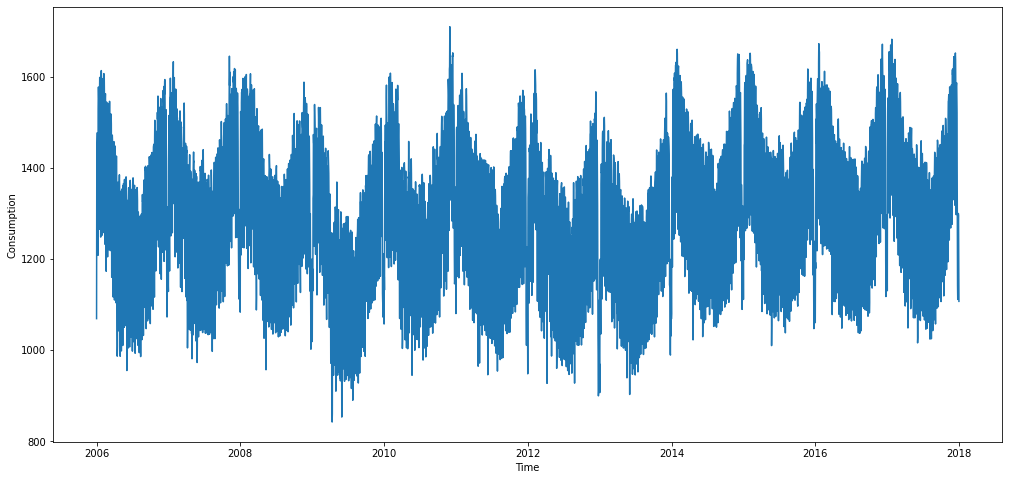

In [ ]:
def plot_data(col):
    plt.figure(figsize=(17, 8))
    plt.plot(df[col])
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.grid(False)
    plt.show()
    
for col in df.columns:
    plot_data(col)

In [98]:
df.tail(30)

,Consumption
Date,
2017-12-02,1391.85405
2017-12-03,1330.26226
2017-12-04,1620.97758
2017-12-05,1643.72307
2017-12-06,1639.08265
2017-12-07,1628.47979
2017-12-08,1618.05658
2017-12-09,1415.34531
2017-12-10,1318.10964


In [59]:
dataset = df.values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

In [99]:
df['Consumption'] = scaled_data

In [100]:
logging.getLogger().setLevel(logging.ERROR)

In [101]:
df = df.reset_index()
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2006-01-01,1069.184
1,2006-01-02,1380.521
2,2006-01-03,1442.533
3,2006-01-04,1457.217
4,2006-01-05,1477.131


In [102]:
prediction_size = 31
train_df = df[:-prediction_size]

In [103]:
train_df['cap'] = 8.5

train_df

,ds,y,cap
0,2006-01-01,1069.18400,8.5
1,2006-01-02,1380.52100,8.5
2,2006-01-03,1442.53300,8.5
3,2006-01-04,1457.21700,8.5
4,2006-01-05,1477.13100,8.5
...,...,...,...
4347,2017-11-26,1276.09818,8.5
4348,2017-11-27,1602.17797,8.5
4349,2017-11-28,1615.38061,8.5
4350,2017-11-29,1603.98435,8.5


# HyperParameter Tunning

In [ ]:
param_grid = {  
                'changepoint_prior_scale': [0.005, 0.05, 0.5, 5],
                'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.1, 1, 10.0],
                'holidays_prior_scale':[0.1, 1, 10.0],
                'seasonality_mode': ['multiplicative', 'additive'],
                'growth': ['linear', 'logistic'],
                'yearly_seasonality': [5, 10, 20]
              }

metrics = ['horizon', 'rmse', 'mape', 'params'] 

results = []

In [65]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

In [66]:
def single_cv_run(history_df, metrics, **param_dict):
    m = Prophet(**param_dict)
    m.fit(history_df)
    df_cv = cross_validation(m, initial='4000 days', horizon = '180 days')
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

In [67]:
def cv_run(**param_dict):
  m = Prophet(**param_dict)

In [ ]:
params_df = create_param_combinations(**param_grid)

In [ ]:
params_df

,changepoint_prior_scale,changepoint_range,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,growth,yearly_seasonality
0,0.005,0.8,0.1,0.1,multiplicative,linear,5
1,0.005,0.8,0.1,0.1,multiplicative,linear,10
2,0.005,0.8,0.1,0.1,multiplicative,linear,20
3,0.005,0.8,0.1,0.1,multiplicative,logistic,5
4,0.005,0.8,0.1,0.1,multiplicative,logistic,10
...,...,...,...,...,...,...,...
859,5.000,0.9,10.0,10.0,additive,linear,10
860,5.000,0.9,10.0,10.0,additive,linear,20
861,5.000,0.9,10.0,10.0,additive,logistic,5
862,5.000,0.9,10.0,10.0,additive,logistic,10


In [ ]:
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(train_df,  metrics, **param_dict)
    results.append(cv_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-03-06 00:00:00 and 2017-06-04 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
param_dict

{'changepoint_prior_scale': 0.005,
 'changepoint_range': 0.8,
 'growth': 'linear',
 'holidays_prior_scale': 0.1,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 0.1,
 'yearly_seasonality': 5}

In [ ]:
results_df = pd.concat(results).reset_index(drop=True)
best_param = results_df.loc[results_df['mape'] == min(results_df['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df

# Modelling

In [104]:
m = Prophet(changepoint_prior_scale= 0.005,
 changepoint_range= 0.8,
 growth= 'linear',
 holidays_prior_scale= 0.1,
 seasonality_mode= 'multiplicative',
 seasonality_prior_scale= 0.1,
 yearly_seasonality= 5)
m.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [105]:
m = Prophet()
m.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [106]:
future = m.make_future_dataframe(periods=prediction_size)

forecast = m.predict(future)

In [107]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          4383 non-null   datetime64[ns]
 1   trend                       4383 non-null   float64       
 2   yhat_lower                  4383 non-null   float64       
 3   yhat_upper                  4383 non-null   float64       
 4   trend_lower                 4383 non-null   float64       
 5   trend_upper                 4383 non-null   float64       
 6   additive_terms              4383 non-null   float64       
 7   additive_terms_lower        4383 non-null   float64       
 8   additive_terms_upper        4383 non-null   float64       
 9   weekly                      4383 non-null   float64       
 10  weekly_lower                4383 non-null   float64       
 11  weekly_upper                4383 non-null   float64     

In [108]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30))

             ds         yhat   yhat_lower   yhat_upper
4353 2017-12-02  1408.925170  1329.126614  1493.372310
4354 2017-12-03  1311.417369  1228.906888  1394.413048
4355 2017-12-04  1596.858228  1515.536394  1677.711215
4356 2017-12-05  1632.099192  1553.909812  1716.861427
4357 2017-12-06  1632.281019  1554.308742  1714.038221
4358 2017-12-07  1613.154466  1535.579615  1692.576500
4359 2017-12-08  1578.499306  1493.915272  1658.032489
4360 2017-12-09  1374.434507  1289.744010  1452.993053
4361 2017-12-10  1265.906798  1182.437303  1355.134110
4362 2017-12-11  1540.607172  1462.817288  1625.380237
4363 2017-12-12  1565.604598  1480.530980  1642.424899
4364 2017-12-13  1556.253369  1474.553512  1640.009347
4365 2017-12-14  1528.508969  1444.633712  1609.829260
4366 2017-12-15  1486.342388  1404.056091  1569.148697
4367 2017-12-16  1276.045841  1196.690724  1356.037749
4368 2017-12-17  1162.717200  1091.629516  1242.441288
4369 2017-12-18  1434.172826  1353.054614  1513.381705
4370 2017-

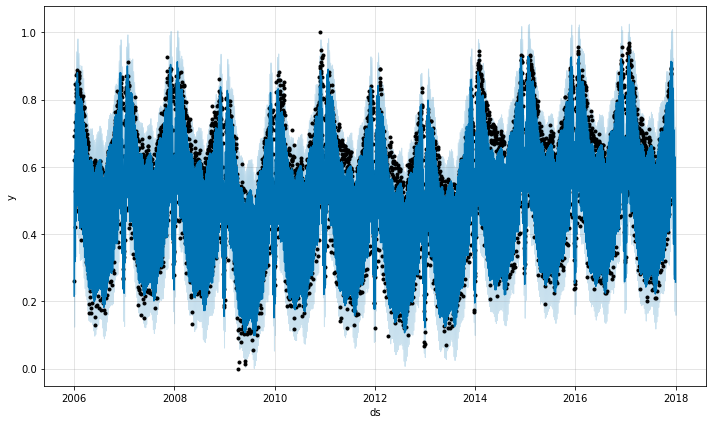

In [51]:
m.plot(forecast)
plt.show()

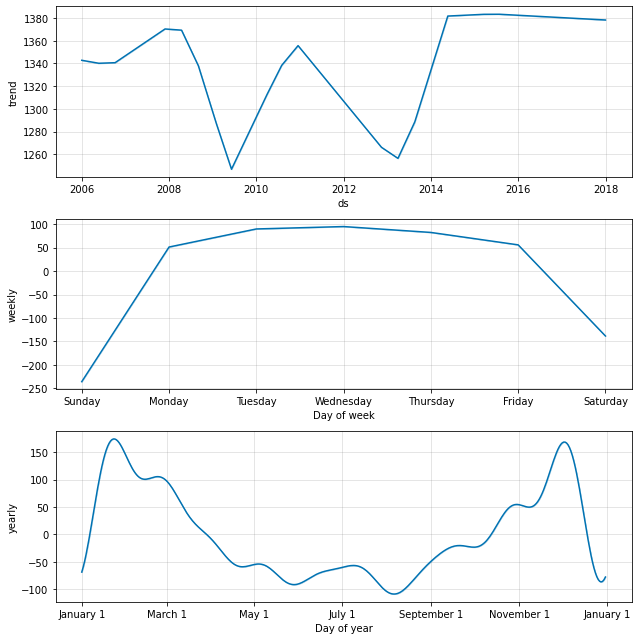

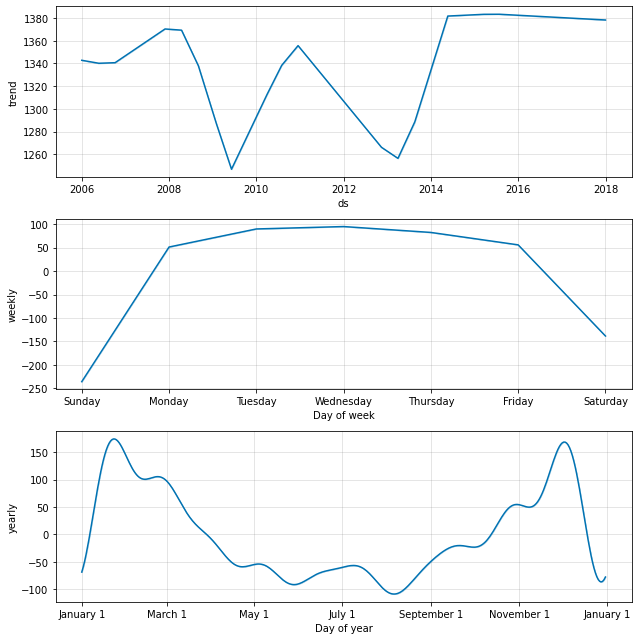

In [ ]:
m.plot_components(forecast)

In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [109]:
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [110]:
cmp_df = make_comparison_dataframe(df, forecast)

cmp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2017-12-27,1387.780657,1303.233818,1467.315330,1263.94091
2017-12-28,1374.087171,1294.634481,1451.639100,1299.86398
2017-12-29,1348.551706,1266.445636,1428.629274,1295.08753
2017-12-30,1157.201934,1080.732552,1237.137974,1215.44897
2017-12-31,1064.824905,982.620538,1153.046292,1107.11488


In [74]:
 cmp_df =scaler.inverse_transform(cmp_df)

In [75]:
cmp_df

array([[1027.30110279,  948.27318353, 1114.70647861, 1069.184     ],
       [1323.25154645, 1246.33958441, 1409.74128338, 1380.521     ],
       [1372.26608072, 1288.7342692 , 1457.12025201, 1442.533     ],
       ...,
       [1350.1892835 , 1269.37994583, 1436.17907469, 1295.08753   ],
       [1158.89486789, 1071.95867817, 1242.12096713, 1215.44897   ],
       [1066.57216572,  991.11829775, 1148.62661349, 1107.11488   ]])

In [111]:
def calculate_forecast_errors(df, prediction_size):
    
    df = df.copy()
    
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [112]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 5.851370791221595
MAE 79.34570467452801


In [ ]:
!pip install prophet.diagnostics

ERROR: Could not find a version that satisfies the requirement prophet.diagnostics (from versions: none)
ERROR: No matching distribution found for prophet.diagnostics


In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='1383 days', period='180 days', horizon = '365 days')

INFO:fbprophet:Making 15 forecasts with cutoffs between 2010-01-07 00:00:00 and 2016-12-01 00:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,7061.739536,84.034157,54.766619,0.043344,0.026494,0.809994
1,38 days,7023.179836,83.804414,54.905566,0.043382,0.027117,0.805484
2,39 days,6859.391209,82.821442,55.001301,0.043199,0.027595,0.800853
3,40 days,6607.008599,81.283508,54.746863,0.042635,0.027678,0.797319
4,41 days,6461.878415,80.385810,54.620158,0.042266,0.027798,0.792687


In [114]:
cmp_df

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2006-01-01,1036.031972,958.572395,1115.270329,1069.18400
2006-01-02,1331.884467,1251.966401,1417.961076,1380.52100
2006-01-03,1380.802641,1294.482143,1452.455886,1442.53300
2006-01-04,1397.770080,1315.522923,1477.391108,1457.21700
2006-01-05,1398.325688,1315.049202,1477.304619,1477.13100
...,...,...,...,...
2017-12-27,1387.780657,1303.233818,1467.315330,1263.94091
2017-12-28,1374.087171,1294.634481,1451.639100,1299.86398
2017-12-29,1348.551706,1266.445636,1428.629274,1295.08753


In [115]:
var=explained_variance_score(cmp_df['y'], cmp_df['yhat']) 

mae=mean_absolute_error(cmp_df['y'], cmp_df['yhat'])
mse=mean_squared_error (cmp_df['y'], cmp_df['yhat'])
rmse=np.sqrt(mse)
r2=r2_score(cmp_df['y'], cmp_df['yhat'])  
metric=[var,mae,mse,rmse,r2]
evaluate=['Explained variance','MAE','MSE','RMSE','R^2']
performance_evaluate=pd.DataFrame([evaluate,metric])
performance_evaluate

,0,1,2,3,4
0,Explained variance,MAE,MSE,RMSE,R^2
1,0.852741,40.055938,4046.023633,63.608361,0.85274


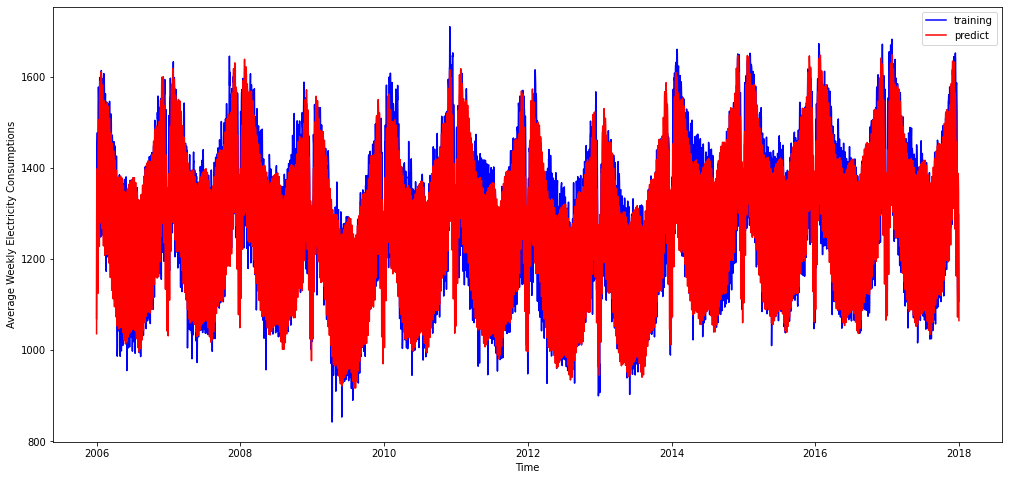

In [116]:
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['y'],label='training',c='b')
plt.plot(cmp_df['yhat'],label='predict',c='r')

plt.xlabel('Time')
plt.ylabel('Average Weekly Electricity Consumptions')
plt.legend()
plt.grid(False)
plt.show()

In [117]:
cmp_df.to_csv('prophet_prediction.csv')